<a href="https://colab.research.google.com/github/sahug/ds-bert/blob/main/BERT%20NLP%20-%20Session%208%20-%20Disaster%20Tweets%20using%20BERT%20-%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BERT NLP - Session 8 - Disaster Tweets using BERT - 2**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Import Data**

Real disaster (1) or not (0)

In [ ]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [ ]:
train_df.shape, test_df.shape

((7613, 5), (3263, 4))

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Chciking Null for Keyword

In [ ]:
train_df.keyword.isnull().sum(), train_df.keyword.notna().sum()

(61, 7552)

Chciking Null for Location

In [ ]:
train_df.location.isnull().sum(), train_df.location.notna().sum()

(2533, 5080)

In [ ]:
train_df[train_df.keyword.notna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


Check Target for 0 and 1

In [ ]:
train_df.groupby("target").describe()

id                                                           \
         count         mean          std   min      25%     50%     75%   
target                                                                    
0       4342.0  5276.446338  3157.206802  23.0  2513.25  5243.5  8038.5   
1       3271.0  5661.608071  3097.094809   1.0  3104.50  5676.0  8252.0   

                 
            max  
target           
0       10848.0  
1       10873.0

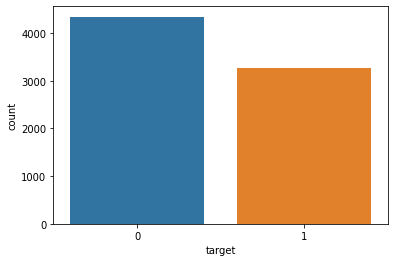

In [ ]:
sns.countplot(x="target", data=train_df)

Check Null for Text

In [ ]:
train_df.text.isnull().sum()

0

**Data Imputation**

Join Keyword, Location and Text to create new input.

In [ ]:
train_df["context"] = (train_df["keyword"]).fillna("") + "." + (train_df["location"]).fillna("") + train_df["text"]  

In [ ]:
train_df["context"]

0       .Our Deeds are the Reason of this #earthquake ...
1                 .Forest fire near La Ronge Sask. Canada
2       .All residents asked to 'shelter in place' are...
3       .13,000 people receive #wildfires evacuation o...
4       .Just got sent this photo from Ruby #Alaska as...
                              ...                        
7608    .Two giant cranes holding a bridge collapse in...
7609    .@aria_ahrary @TheTawniest The out of control ...
7610    .M1.94 [01:04 UTC]?5km S of Volcano Hawaii. ht...
7611    .Police investigating after an e-bike collided...
7612    .The Latest: More Homes Razed by Northern Cali...
Name: context, Length: 7613, dtype: object

In [ ]:
train_df.context.notna().sum()

7613

**Data Cleaning**

In [ ]:
train_df = train_df.drop(["id", "keyword", "location", "text"], axis=1)

In [ ]:
train_df.head()

,target,context
0,1,.Our Deeds are the Reason of this #earthquake ...
1,1,.Forest fire near La Ronge Sask. Canada
2,1,.All residents asked to 'shelter in place' are...
3,1,".13,000 people receive #wildfires evacuation o..."
4,1,.Just got sent this photo from Ruby #Alaska as...


In [ ]:
train_f = train_df["context"] #Training Feature
train_t = train_df["target"] #Training Target

train_f.shape, train_t.shape

((7613,), (7613,))

Build Model

In [ ]:
%pip install -qq tensorflow-cpu

In [ ]:
%pip install -U -qq tensorflow-text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_f, train_t, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5100,), (2513,), (5100,), (2513,))

**Download BERT Prepocessing**

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

**Build Model Using Keras**

In [ ]:
#Here we will sue the Fubnctional way and not the Sequential way to build the model

#BERT layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text_input")
preprocessed_ip = bert_preprocess(text_input)
preprocessed_op = bert_encoder(preprocessed_ip)

#NN
nn1 = tf.keras.layers.Dropout(0.1, name="dropout")(preprocessed_op["pooled_output"])
nn1 = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(nn1)

#Final Model
model = tf.keras.Model(inputs=[text_input], outputs=[nn1])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text_input[0][0]']             
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

**Define Metrices to capture**

In [ ]:
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name="Accuracy"),
           tf.keras.metrics.Precision(name="Precision"),
           tf.keras.metrics.Recall(name="Recall"),
]

**Compile Model**

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)

**Fit Model**

In [ ]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
160/160 [==============================] - 2303s 14s/step - loss: 0.6465 - Accuracy: 0.6200 - Precision: 0.5814 - Recall: 0.4310
Epoch 2/3
160/160 [==============================] - 2278s 14s/step - loss: 0.6013 - Accuracy: 0.6831 - Precision: 0.6544 - Recall: 0.5653
Epoch 3/3
160/160 [==============================] - 2269s 14s/step - loss: 0.5898 - Accuracy: 0.6957 - Precision: 0.6668 - Recall: 0.5912


**Evaluate Model**

In [ ]:
model.evaluate(X_test, y_test)

79/79 [==============================] - 1116s 14s/step - loss: 0.5776 - Accuracy: 0.7035 - Precision: 0.6231 - Recall: 0.7638


[0.5775609612464905,
 0.7035415768623352,
 0.6230886578559875,
 0.7638238072395325]

**Prediction**

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
#Doing this beqacuse the y_predictyed has floating points and we need the output in 0 and 1. 
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[953, 493],
       [252, 815]])

Text(33.0, 0.5, 'Truth')

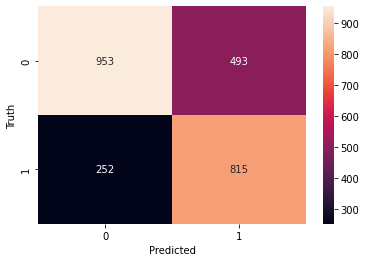

In [ ]:
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      1446
           1       0.62      0.76      0.69      1067

    accuracy                           0.70      2513
   macro avg       0.71      0.71      0.70      2513
weighted avg       0.72      0.70      0.71      2513

